# Jupyter Notebook to compare 2 Match-up Satellite products

## Load necessary libraries

In [1]:
# Load necessary libraries
import os, sys
from pathlib import Path
import numpy as np
from scipy import stats
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
%matplotlib inline
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from datetime import datetime, date, timedelta
import ipywidgets as widgets
from IPython.display import display, Image
# Add custom scripts to Python path
sys.path.append(os.path.realpath('../scripts/'))
from grid_stats import make_griddata_stat
from netcdf_utils import quick_download
from sss_geophysical_analysis_plotter import plot_deltaSSS_sorted_by_geophys_cond
from pimep_config import PIMEPConfig, setup_pimep_plotting
config = PIMEPConfig()
#setup_pimep_plotting()

## Set local path to Matchup Data and python function

In [2]:
# Remote data URL
url_pimep_web = 'https://pimep.ifremer.fr/diffusion/'
# Local data directory
mdb_data_path = Path('../data/data_concat/')
# Ensure the local data directory exists
Path(mdb_data_path).mkdir(parents=True, exist_ok=True)
mask_path = Path('../data/mask/')
# Ensure the mask directory exists
mask_path.mkdir(parents=True, exist_ok=True)

## Select the SSS products to compare whith the In situ dataset and the region of interest

In [4]:
satellite_map = config.satellite_map
insitu_map    = config.insitu_map
region_map    = config.region_map

SATELLITE_OPTIONS = [(label, id_) for id_, label in satellite_map.items()]
INSITU_OPTIONS    = [(label, id_) for id_, label in insitu_map.items()]
REGION_OPTIONS    = [(label, id_) for id_, label in region_map.items()]

default_sat1_value = 'smos-l3-catds-locean-v9-9d'
default_sat1_index = next((i for i, (label, _id) in enumerate(SATELLITE_OPTIONS) if _id == default_sat1_value), 0)

default_sat2_value = 'smos-l3-catds-locean-v10-9d'
default_sat2_index = next((i for i, (label, _id) in enumerate(SATELLITE_OPTIONS) if _id == default_sat2_value), 0)


# Create a user interface for selecting satellite data products, regions, and in-situ data

# Enhanced styling
widget_style = {
    'description_width': '120px'
}

widget_layout = widgets.Layout(
    width='600px',
    margin='5px 0px'
)

# Create styled widgets with explicit index selection for default values
sat1_widget = widgets.Dropdown(
    options=SATELLITE_OPTIONS,
    index=default_sat1_index, 
    description='🛰️ Satellite 1:',
    style=widget_style,
    layout=widget_layout
)

sat2_widget = widgets.Dropdown(
    options=SATELLITE_OPTIONS,
    index=default_sat2_index,
    description='🛰️ Satellite 2:',
    style=widget_style,
    layout=widget_layout
)

region_widget = widgets.Dropdown(
    options=REGION_OPTIONS,
    index=0,  # Index for 'GO'
    description='🌍 Region:',
    style=widget_style,
    layout=widget_layout
)

insitu_widget = widgets.Dropdown(
    options=INSITU_OPTIONS,
    index=0,  # Index for 'argo'
    description='📊 In situ:',
    style=widget_style,
    layout=widget_layout
)

# Create a nice layout container
title = widgets.HTML(
    value="<h3 style='color: #2E86AB; margin-bottom: 10px;'>🌊 Match-up Data Selection Panel</h3>"
)

# Group satellite widgets
satellite_box = widgets.VBox([
    widgets.HTML("<h4 style='color: #A23B72; margin: 10px 0px;'>Select Satellite Data Products</h4>"),
    sat1_widget,
    sat2_widget
], layout=widgets.Layout(margin='10px 0px'))

# INSITU widgets
insitu_box = widgets.VBox([
    widgets.HTML("<h4 style='color: #A23B72; margin: 5px 0px;'>Select In Situ Data</h4>"),
    insitu_widget
], layout=widgets.Layout(margin='5px 0px'))

# Group other widgets  
region_box = widgets.VBox([
    widgets.HTML("<h4 style='color: #A23B72; margin: 5px 0px;'>Select Region</h4>"),
    region_widget
], layout=widgets.Layout(margin='5px 0px'))

# Main container
main_container = widgets.VBox([
    title,
    satellite_box,
    insitu_box,
    region_box
], layout=widgets.Layout(
    border='2px solid #E8E8E8',
    padding='20px',
    border_radius='10px',
    background_color='#FAFAFA',
    width='700px'
))

# Display the styled interface
display(main_container)


## Load Selected Match-up files

In [6]:

pathdataset1 = mdb_data_path / sat1_widget.value / f'pimep-mdb-data-reduced_{sat1_widget.value}_{insitu_widget.value}.nc'
if not pathdataset1.exists():
    print(f"Downloading dataset for {sat1_widget.label} and {insitu_widget.label}...")
    url1 = url_pimep_web + 'data_concat/' + sat1_widget.value + f'/pimep-mdb-data-reduced_{sat1_widget.value}_{insitu_widget.value}.nc'
    ds1 = quick_download(url1,"../data/data_concat/" + sat1_widget.value + "/", use_wget=False)
else:
    print(f"Dataset for {sat1_widget.label} and {insitu_widget.label} already exists. Loading from local path.")
    ds1 = xr.open_mfdataset(pathdataset1, decode_timedelta=False)

pathdataset2 = mdb_data_path / sat2_widget.value / f'pimep-mdb-data-reduced_{sat2_widget.value}_{insitu_widget.value}.nc'
if not pathdataset2.exists():
    print(f"Downloading dataset for {sat2_widget.label} and {insitu_widget.label}...")
    url2 = url_pimep_web + 'data_concat/' + sat2_widget.value + f'/pimep-mdb-data-reduced_{sat2_widget.value}_{insitu_widget.value}.nc'
    ds2 = quick_download(url2, "../data/data_concat/" + sat2_widget.value + "/", use_wget=False)
else:
    print(f"Dataset for {sat2_widget.label} and {insitu_widget.label} already exists. Loading from local path.")
    ds2 = xr.open_mfdataset(pathdataset2, decode_timedelta=False)

ds1.load()
ds2.load()

# Define the variables to keep in the datasets
coloc_variables = [ 'DATE', 'LATITUDE', 'LONGITUDE','SSS', 'SST', 'SSS_DEPTH', 'DELAYED_MODE',
    'PLATFORM_NUMBER', 'CYCLE_NUMBER', 'MLD',
    'DATE_Satellite_product', 'LATITUDE_Satellite_product', 'LONGITUDE_Satellite_product', 'SSS_Satellite_product', 'SST_Satellite_product',
    'Spatial_lags', 'Time_lags',
    'DISTANCE_TO_COAST','DISTANCE_TO_ICE_EDGE', 'ROSSBY_RADIUS', 'BATHYMETRY_ETOPO1','SEA_ICE_CONCENTRATION',
    'WIND_SPEED_ASCAT_daily', 'WIND_STRESS_X_CMEMS_6h', 'WIND_STRESS_Y_CMEMS_6h', 'WIND_SPEED_CMEMS_6h', 'WIND_SPEED_MAXSS_1h', 'WIND_SPEED_CCMP_6h',
    'RAIN_RATE_CMORPH_3h','RAIN_RATE_IMERG_30min','EVAPORATION_OAFLUX',
    'SSS_ISAS', 'SSS_PCTVAR_ISAS','SSS_ISAS17', 'SSS_PCTVAR_ISAS17', 'SSS_ISAS20', 'SSS_PCTVAR_ISAS20',
    'SSS_WOA18', 'SSS_STD_WOA18', 'SSS_WOA23', 'SSS_STD_WOA23', 
    'CDM_GLOBCOLOUR', 'CHL1_GLOBCOLOUR',
    'SSS_SCRIPPS', 'SSS_IPRC','SSS_SSD_CMEMS', 'SSS_EN4', 'SSS_UNCERTAINTY_EN4',
    'U_CMEMS_GLOBCURRENT', 'V_CMEMS_GLOBCURRENT', 'U_OSCAR_CURRENT', 'V_OSCAR_CURRENT', 'SLA',
    'SSS_GLORYS', 'SSS_WOA23_025', 'SSS_STD_WOA23_025',
    'SST_AVHRR', 'SST_OSTIA', 'SST_CMC', 'SST_RSS', 
    'ERA5_SHWW', 'ERA5_SWH', 'ERA5_PP1D', 'ERA5_MPWW', 'ERA5_U10', 'ERA5_V10', 'ERA5_RELATIVE_HUMIDITY', 'ERA5_SST', 'ERA5_BOUNDARY_LAYER_HEIGHT', 'ERA5_2m_TEMPERATURE', 'ERA5_MEAN_SEA_LEVEL_PRESSURE',
    'SSS_ECCO_RMSD_Aquarius_Argo', 'SSS_ECCO_RMSD_SMAP_Argo', 'SSS_ECCO_RMSD_SMOS_Argo', 'SSS_GLORYS_AT_ARGO_DEPTH',
    'SSS_MEAN_GLORYS_AT_Satellite_product_resolution',
    'SSS_STD_GLORYS_AT_Satellite_product_resolution',
    'SSS_MEAN_GLORYS_AT_Satellite_product_temporal_resolution',
    'SSS_STD_GLORYS_AT_Satellite_product_temporal_resolution',
    'SSS_MEAN_GLORYS_AT_Satellite_product_spatial_resolution',
    'SSS_STD_GLORYS_AT_Satellite_product_spatial_resolution',
    'PIMEP_INDEX'
]

#ds1 = ds1[coloc_variables] # keep only variables you are interested in
#ds2 = ds2[coloc_variables] # keep only variables you are interested in

# Keep only realistics SSS value in each datasets using boolean masks
if ds1.SSS_Satellite_product.min().values<0 or ds2.SSS_Satellite_product.min().values<0 or ds1.SSS_Satellite_product.max().values>42 or ds2.SSS_Satellite_product.max().values>42:
    print("Warning: Out of range [0 42] values found in SSS_Satellite_product. Applying mask to filter out invalid data.")
    mask1 = ((ds1.SSS_Satellite_product>=0) & (ds1.SSS_Satellite_product<42))
    mask2 = ((ds2.SSS_Satellite_product>=0) & (ds2.SSS_Satellite_product<42))
    ds1 = ds1.where(mask1, drop=True)
    ds2 = ds2.where(mask2, drop=True)

print(f"LOAD MDB File SAT1: {pathdataset1}")
print(f"LOAD MDB File SAT2: {pathdataset2}")
print(f"Number of points in dataset 1: {ds1.SSS_Satellite_product.size}")
print(f"Number of points in dataset 2: {ds2.SSS_Satellite_product.size}")

INFO:netcdf_utils:Using requests for download


INFO:netcdf_utils:Starting download: https://pimep.ifremer.fr/diffusion/data_concat/smap-l2-jpl-v5.0/pimep-mdb-data-reduced_smap-l2-jpl-v5.0_tsg-legos-pacific.nc
INFO:netcdf_utils:File size: 182.6 MB
pimep-mdb-data-reduced_smap-l2-jpl-v5.0_tsg-legos-pacific.nc: 100%|██████████| 183M/183M [00:17<00:00, 10.9MB/s] 
INFO:netcdf_utils:Download completed in 17.9s
INFO:netcdf_utils:Average speed: 10.2 MB/s
INFO:netcdf_utils:File successfully downloaded to: ../data/data_concat/smap-l2-jpl-v5.0/pimep-mdb-data-reduced_smap-l2-jpl-v5.0_tsg-legos-pacific.nc
INFO:netcdf_utils:Opening dataset with xarray...
INFO:netcdf_utils:Using requests for download
INFO:netcdf_utils:Starting download: https://pimep.ifremer.fr/diffusion/data_concat/smap-l2-rss-v6/pimep-mdb-data-reduced_smap-l2-rss-v6_tsg-legos-pacific.nc
INFO:netcdf_utils:File size: 152.1 MB


pimep-mdb-data-reduced_smap-l2-rss-v6_tsg-legos-pacific.nc: 100%|██████████| 152M/152M [00:19<00:00, 8.10MB/s] 
INFO:netcdf_utils:Download completed in 19.9s
INFO:netcdf_utils:Average speed: 7.7 MB/s
INFO:netcdf_utils:File successfully downloaded to: ../data/data_concat/smap-l2-rss-v6/pimep-mdb-data-reduced_smap-l2-rss-v6_tsg-legos-pacific.nc
INFO:netcdf_utils:Opening dataset with xarray...


LOAD MDB File SAT1: ../data/data_concat/smap-l2-jpl-v5.0/pimep-mdb-data-reduced_smap-l2-jpl-v5.0_tsg-legos-pacific.nc
LOAD MDB File SAT2: ../data/data_concat/smap-l2-rss-v6/pimep-mdb-data-reduced_smap-l2-rss-v6_tsg-legos-pacific.nc
Number of points in dataset 1: 4576428
Number of points in dataset 2: 3689009


## Find common PIMEP INDEX values

In [7]:
# Convert PIMEP_INDEX to a pandas Series
pimep_series1 = pd.Series(ds1['PIMEP_INDEX'].values)
pimep_series2 = pd.Series(ds2['PIMEP_INDEX'].values)

# Get mask that is True only for the first occurrence of each unique value
unique_mask1 = ~pimep_series1.duplicated(keep='first')
unique_mask2 = ~pimep_series2.duplicated(keep='first')

# Apply the mask to filter ds1
ds1_unique = ds1.isel(time=unique_mask1)
ds2_unique = ds2.isel(time=unique_mask2)
print(f"Filtered unique ds1: {ds1_unique.sizes['time']}, ds2: {ds2_unique.sizes['time']}")

# Sort by index values
ds1 = ds1_unique.sortby(ds1_unique.PIMEP_INDEX)
ds2 = ds2_unique.sortby(ds2_unique.PIMEP_INDEX)

# Find common values between the coordinate variables
common_indices = np.intersect1d(ds1.PIMEP_INDEX.values, ds2.PIMEP_INDEX.values)

print(f"Found {len(common_indices)} common indices out of {ds1.sizes['time']} and {ds2.sizes['time']}")

# Build boolean masks along 'time' dimension
mask1 = ds1.PIMEP_INDEX.isin(common_indices)
mask2 = ds2.PIMEP_INDEX.isin(common_indices)

# Now filter
ds1 = ds1.sel(time=mask1)
ds2 = ds2.sel(time=mask2)

same_size = ds1.sizes == ds2.sizes
print(f"Same dimensions and sizes: {same_size}")
same_longitude = ds1.LONGITUDE.equals(ds2.LONGITUDE)
print(f"LONGITUDE arrays are identical: {same_longitude}")

same_latitude = ds1.LATITUDE.equals(ds2.LATITUDE)
print(f"LATITUDE arrays are identical: {same_latitude}")


Filtered unique ds1: 3582330, ds2: 2977406
Found 2903461 common indices out of 3582330 and 2977406
Same dimensions and sizes: True
LONGITUDE arrays are identical: True
LATITUDE arrays are identical: True


## Keep data only in the selected region

In [8]:
# Load the mask dataset for the selected region
mask = mask_path / f'pimep-region_{region_widget.value}.nc'
if not mask.exists():
    print(f"Downloading Mask file for {region_widget.label}...")
    url = url_pimep_web + f'pimep-region_{region_widget.value}.nc'
    ds_mask = quick_download(url, mask, use_wget=False)
else:
    print(f"Mask file for {region_widget.label} already exists. Loading from local path.")
    ds_mask = xr.open_mfdataset(mask)
mask_data = ds_mask.PIMEP_REGION_MASK.load()
mask_at_data_points = mask_data.interp(
    Lon=ds1.LONGITUDE, 
    Lat=ds1.LATITUDE, 
    method='nearest'
)

# Keep only points where mask = 1
valid_mask = mask_at_data_points == 1
ds1 = ds1.where(valid_mask, drop=True)
ds2 = ds2.where(valid_mask, drop=True)

dSSS = ds1.SSS_Satellite_product - ds1.SSS
ds1['dSSS']=dSSS
dSSS = ds2.SSS_Satellite_product - ds2.SSS
ds2['dSSS']=dSSS

Mask file for Pacific Ocean already exists. Loading from local path.


## Plot the Number of Match-up vs time

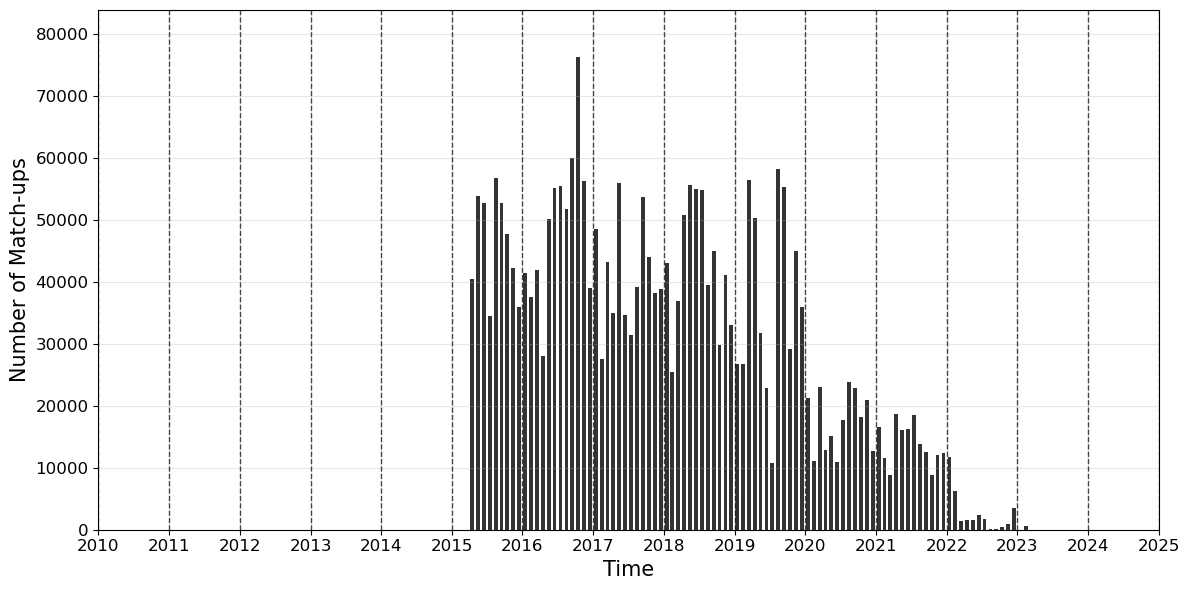

In [9]:
def plot_sss_vs_time(mdb, insitu_id, region_id, sat_id, filename):
    """
    Plot number of SSS match-ups vs time, with optional mode separation for Argo data.
    
    Parameters:
    -----------
    mdb : dict or object
        Database containing 'DATE' and 'DELAYED_MODE' fields
    insitu_id : str
        In-situ instrument identifier (e.g., 'argo')
    region_id : str
        Region identifier
    sat_id : str
        Satellite identifier
    filename : str 
        Path for saving figures
    """
    
    # Clear and setup figure
    plt.figure(figsize=(12, 6))
    plt.clf()
    
    # Check if there's data to plot
    if len(mdb['DATE_Satellite_product']) == 0:
        return
    
    # Create time bins (monthly from 2010 to 2025)
    start_date = datetime(2010, 1, 1)
    end_date = datetime(2025, 12, 31)
    time_bins = pd.date_range(start=start_date, end=end_date, freq='ME')
    bin_centers = time_bins[:-1] + (time_bins[1:] - time_bins[:-1]) / 2
    # Get all dates from the dataset
    y_dates = mdb['DATE_Satellite_product']
    
    # Handle Argo data with mode separation
    if insitu_id == 'argo':
        # Separate delayed mode and real-time data
        delayed_mask = mdb['DELAYED_MODE'] == 1
        realtime_mask = mdb['DELAYED_MODE'] == 0
        
        # Create histograms
        n_delayed, _ = np.histogram(y_dates[delayed_mask], bins=time_bins)
        n_realtime, _ = np.histogram(y_dates[realtime_mask], bins=time_bins)
        
        # Create stacked bar plot
        plt.bar(bin_centers, n_delayed, width=20, label=f'Delayed mode ({np.sum(delayed_mask)/len(y_dates)*100:.0f}%)', 
                color='black', alpha=0.8)
        plt.bar(bin_centers, n_realtime, width=20, bottom=n_delayed, 
                label=f'Real time ({np.sum(realtime_mask)/len(y_dates)*100:.0f}%)', 
                color='#0A73E8', alpha=0.8)
        
        max_count = np.max(n_delayed + n_realtime)
        
        # Add legend
        plt.legend(loc='upper left', frameon=False, fontsize=14)
        
    else:
        # Regular histogram for non-Argo data
        n_counts, _ = np.histogram(y_dates, bins=time_bins)
        plt.bar(bin_centers, n_counts, width=20, color='black', alpha=0.8)
        max_count = np.max(n_counts)
    
    # Add year separator lines
    for year in range(2010, 2026):
        year_start = datetime(year, 1, 1)
        plt.axvline(year_start, color='black', linestyle='--', linewidth=1, alpha=0.7)
    
    # Set axis limits and labels
    max_date = pd.to_datetime(y_dates.max().values)  # Convert to pandas datetime
    plt.xlim(datetime(2010, 1, 1), max_date + timedelta(days=30))
    plt.ylim(0, max_count * 1.1)
    
    # Format x-axis
    years = range(2010, 2026)
    year_dates = [datetime(year, 1, 1) for year in years]
    plt.xticks(year_dates, [str(year) for year in years], fontsize=12)
    
    # Labels and formatting
    plt.ylabel('Number of Match-ups', fontsize=15)
    plt.xlabel('Time', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid(True, alpha=0.3)
    
    # Save figure
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


filename = f'../output/figures/pimep-mdb-figure_{region_widget.value}_{sat1_widget.value}_{insitu_widget.value}_Number-of-SSS-vs-time.png'
plot_sss_vs_time(ds1, insitu_widget.value, region_widget.value, sat1_widget.value, filename)

## SSS distribution plots

/var/folders/0h/7mztc0950dn6896kpc98nwrr0000gn/T/ipykernel_39898/3293547930.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


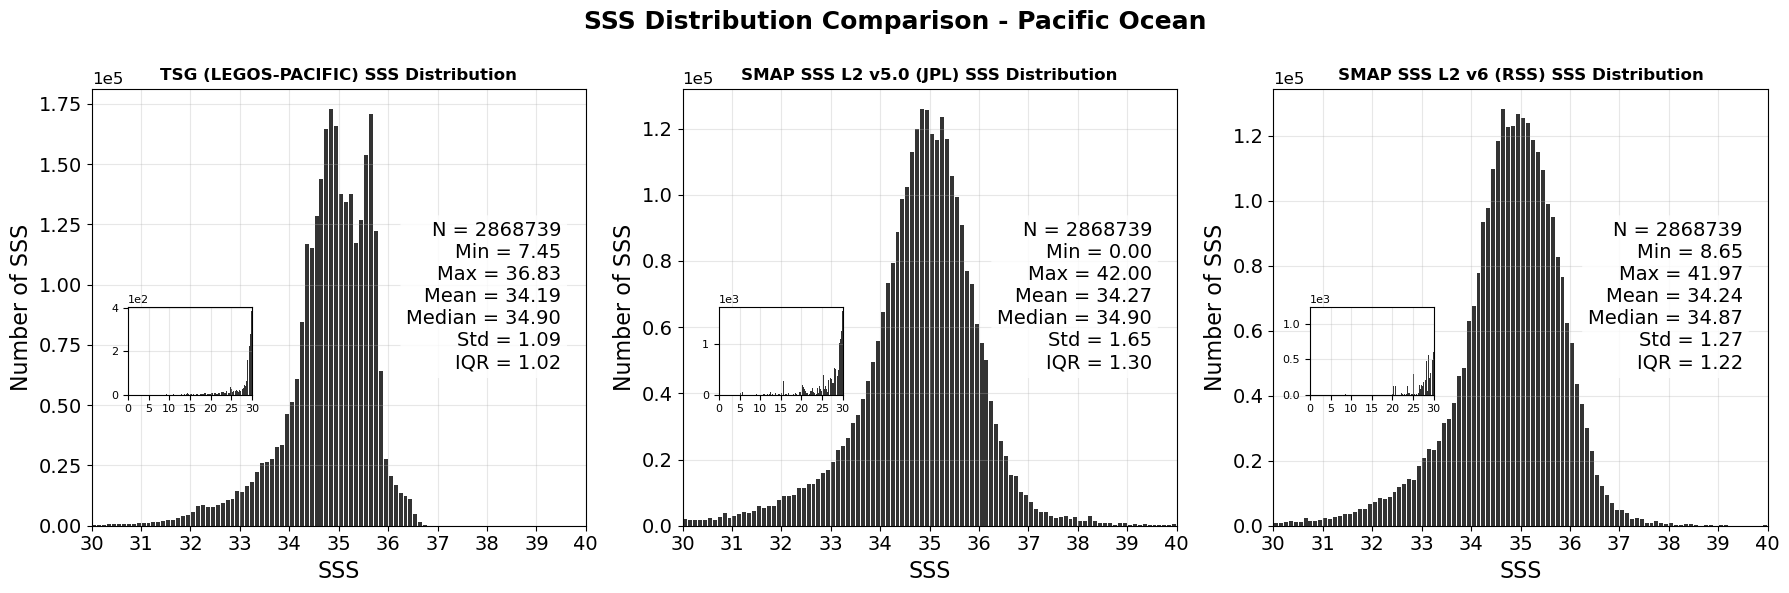

In [24]:
def plot_sss_distribution_sidebyside(mdb_list, vars_list, labels_list, insitu_id, insitu_name, region_id, sat_id, filename):
    """
    Plot SSS distribution histograms side by side with optional mode separation for Argo data.
    
    Parameters:
    -----------
    mdb_list : list
        List of databases containing SSS data (e.g., [ds1, ds1, ds2] for in-situ, sat1, sat2)
    vars_list : list
        List of variable names to plot (e.g., ['SSS', 'SSS_Satellite_product', 'SSS_Satellite_product'])
    labels_list : list
        List of labels for each variable (e.g., ['In-situ', 'Satellite 1', 'Satellite 2'])
    insitu_id : str
        In-situ instrument identifier (e.g., 'argo')
    insitu_name : str
        In-situ instrument display name
    region_id : str
        Region identifier
    sat_id : str
        Satellite identifier
    filename : str
        Filename for saving the figure
    """
    
    # Define histogram bins
    nb = np.arange(30, 40.1, 0.1)  # 30:0.1:40
    nb1 = np.arange(0, 30.1, 0.1)  # 0:0.1:30
    
    # Create figure with subplots side by side
    n_plots = len(vars_list)
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
    
    # Ensure axes is always a list
    if n_plots == 1:
        axes = [axes]
    
    for idx, (mdb, var_name, label) in enumerate(zip(mdb_list, vars_list, labels_list)):
        ax = axes[idx]
        
        # Check if there's data to plot
        if len(mdb[var_name]) == 0:
            ax.text(0.5, 0.5, 'No data available', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=16)
            continue
        
        # Get SSS values
        y = mdb[var_name]
        
        # Remove NaN values
        y_clean = y[~np.isnan(y)]
        
        if len(y_clean) == 0:
            ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=16)
            continue
        
        optsub = False  # Flag for subplot
        
        # Handle Argo data with mode separation
        if insitu_id == 'argo' and var_name == 'SSS':  # Only apply mode separation to in-situ data
            # Separate delayed mode and real-time data
            delayed_mask = mdb['DELAYED_MODE'] == 1
            realtime_mask = mdb['DELAYED_MODE'] == 0
            
            # Get SSS values for each mode
            y_delayed = y[delayed_mask]
            y_realtime = y[realtime_mask]
            
            # Remove NaN values
            y_delayed_clean = y_delayed[~np.isnan(y_delayed)]
            y_realtime_clean = y_realtime[~np.isnan(y_realtime)]
            
            # Create histograms
            n_delayed, bin_edges = np.histogram(y_delayed_clean, bins=nb)
            n_realtime, _ = np.histogram(y_realtime_clean, bins=nb)
            
            # Calculate bin centers
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Create stacked bar plot
            ax.bar(bin_centers, n_delayed, width=0.08, 
                   label=f'Delayed mode ({len(y_delayed_clean)/len(y_clean)*100:.0f}%)', 
                   color='black', alpha=0.8)
            ax.bar(bin_centers, n_realtime, width=0.08, bottom=n_delayed,
                   label=f'Real time ({len(y_realtime_clean)/len(y_clean)*100:.0f}%)', 
                   color='#0A73E8', alpha=0.8)
            
            max_count = np.max(n_delayed + n_realtime)
            
            # Add legend
            ax.legend(loc='upper left', frameon=False, fontsize=12)
            
            # Check if we need subplot for values < 30
            if np.any(y_clean < 30):
                optsub = True
                
        else:
            # Regular histogram for non-Argo data or satellite data
            n_counts, bin_edges = np.histogram(y_clean, bins=nb)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            ax.bar(bin_centers, n_counts, width=0.08, color='black', alpha=0.8)
            max_count = np.max(n_counts)
            
            # Check if we need subplot for values < 30
            if np.any(y_clean < 30):
                optsub = True
        
        # Set axis limits and labels
        ax.set_xlim(30, 40)
        ax.set_ylim(0, max_count * 1.05)
        
        # Format x-axis
        ax.set_xticks(range(30, 41, 1))
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Format y-axis in scientific notation to save space
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        ax.yaxis.get_offset_text().set_fontsize(12)
        
        # Add statistics text
        stats_text = generate_legend_stats(y_clean)
        ax.text(39.5, max_count * 0.55, stats_text, 
                ha='right', va='center', fontsize=14,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.3'))
        
        # Labels and formatting
        ax.set_ylabel(f'Number of SSS', fontsize=16)
        ax.set_xlabel('SSS', fontsize=16)
        ax.grid(True, alpha=0.3)
        ax.set_title(f'{label} SSS Distribution', fontsize=12, fontweight='bold')
        
        # Add subplot for values < 30 if needed
        if optsub:
            # Create inset axes for subplot
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes
            
            ax_inset = inset_axes(ax, width="25%", height="20%", 
                                 loc='center left', bbox_to_anchor=(0.06, -0.1, 1, 1),
                                 bbox_transform=ax.transAxes)
            
            if insitu_id == 'argo' and var_name == 'SSS':
                # Filter data < 30 for each mode
                y_delayed_sub = y_delayed_clean[y_delayed_clean < 30]
                y_realtime_sub = y_realtime_clean[y_realtime_clean < 30]
                
                if len(y_delayed_sub) > 0 or len(y_realtime_sub) > 0:
                    # Create histograms for subplot
                    n_delayed_sub, bin_edges_sub = np.histogram(y_delayed_sub, bins=nb1)
                    n_realtime_sub, _ = np.histogram(y_realtime_sub, bins=nb1)
                    
                    bin_centers_sub = (bin_edges_sub[:-1] + bin_edges_sub[1:]) / 2
                    
                    # Plot stacked bars in subplot
                    ax_inset.bar(bin_centers_sub, n_delayed_sub, width=0.08, 
                               color='black', alpha=0.8)
                    ax_inset.bar(bin_centers_sub, n_realtime_sub, width=0.08, 
                               bottom=n_delayed_sub, color='#0A73E8', alpha=0.8)
                    
                    max_count_sub = np.max(n_delayed_sub + n_realtime_sub)
                    ax_inset.set_ylim(0, max_count_sub * 1.05)
            else:
                # Filter data < 30 for non-Argo or satellite data
                y_sub = y_clean[y_clean < 30]
                
                if len(y_sub) > 0:
                    n_counts_sub, bin_edges_sub = np.histogram(y_sub, bins=nb1)
                    bin_centers_sub = (bin_edges_sub[:-1] + bin_edges_sub[1:]) / 2
                    
                    ax_inset.bar(bin_centers_sub, n_counts_sub, width=0.08, 
                               color='black', alpha=0.8)
                    
                    max_count_sub = np.max(n_counts_sub)
                    ax_inset.set_ylim(0, max_count_sub * 1.05)
            
            # Format subplot
            ax_inset.set_xlim(0, 30)
            ax_inset.set_xticks(range(0, 31, 5))
            ax_inset.tick_params(axis='both', which='major', labelsize=8)
            ax_inset.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
            ax_inset.yaxis.get_offset_text().set_fontsize(8)
            ax_inset.grid(True, alpha=0.3)
    
    # Add overall title
    fig.suptitle(f'SSS Distribution Comparison - {region_id}', 
                fontsize=18, fontweight='bold', y=0.98)
    
    # Save figure
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()


def generate_legend_stats(data):
    """
    Generate statistics text similar to MATLAB's legend_stat function.
    
    Parameters:
    -----------
    data : array-like
        SSS data values
        
    Returns:
    --------
    str : Formatted statistics string
    """
    if len(data) == 0:
        return "No data"
    
    # Calculate statistics
    n_points = len(data)
    mean_val = np.mean(data)
    median_val = np.median(data)
    iqr = stats.iqr(data, nan_policy='omit')
    std_val = np.std(data, ddof=1)  # Use sample standard deviation
    min_val = np.min(data)
    max_val = np.max(data)
    
    # Format statistics string
    stats_str = f"""N = {n_points}
Min = {min_val:.2f}
Max = {max_val:.2f}
Mean = {mean_val:.2f}
Median = {median_val:.2f}
Std = {std_val:.2f}
IQR = {iqr:.2f}"""
    
    return stats_str


# Usage example:
filename = f'../output/figures/pimep-mdb-figure_{region_widget.value}_{sat1_widget.value}_{sat2_widget.value}_{insitu_widget.value}_SSS-distribution-comparison.png'

plot_sss_distribution_sidebyside(
    mdb_list=[ds1, ds1, ds2],
    vars_list=['SSS', 'SSS_Satellite_product', 'SSS_Satellite_product'],
    labels_list=[insitu_widget.label, sat1_widget.label, sat2_widget.label],
    insitu_id=insitu_widget.label,
    insitu_name=insitu_widget.label,
    region_id=region_widget.label,
    sat_id=sat1_widget.label,
    filename=filename
)

## Density Scatter plots

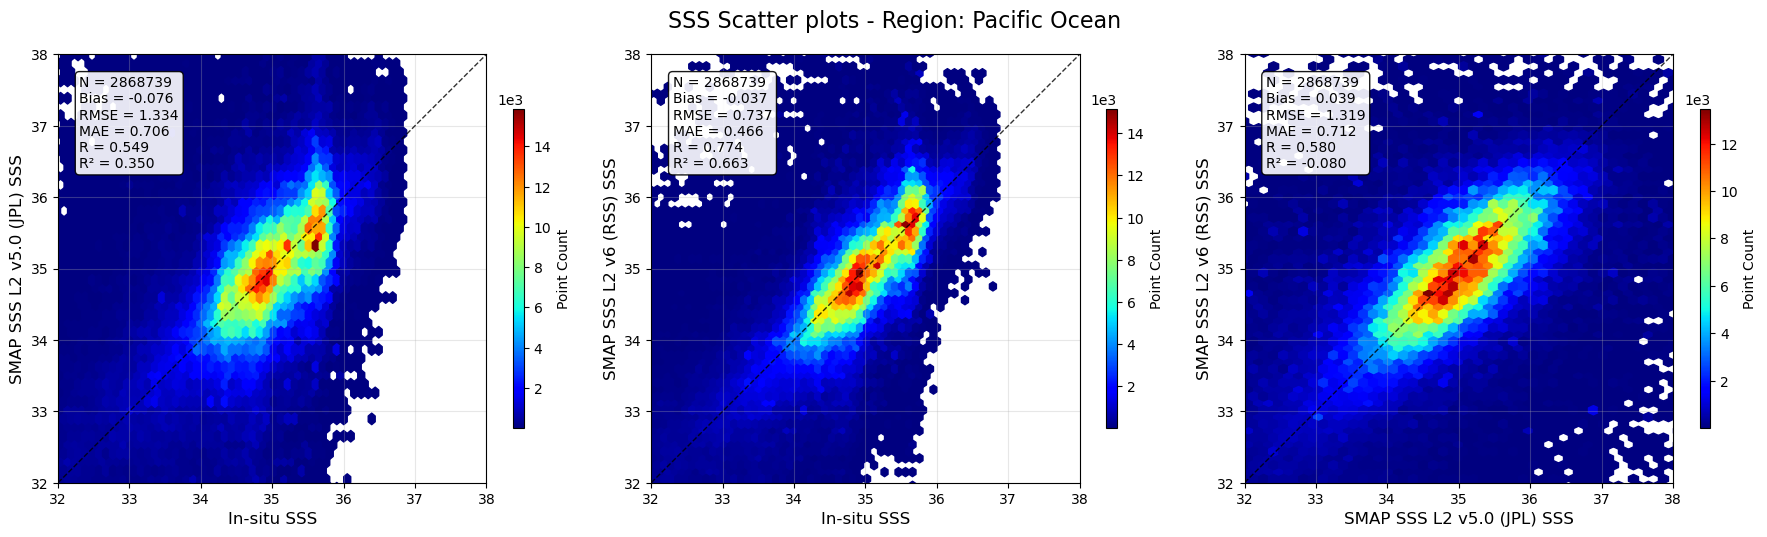

In [29]:
def setup_subplot(ax, x, y, xlabel, ylabel, title, xlim=None, ylim=None):
    """
    Setup individual subplot with 1:1 line, limits, and statistics.
    
    Parameters:
    -----------
    ax : matplotlib axis
        Subplot axis
    x, y : array-like
        Data for x and y axes
    xlabel, ylabel : str
        Axis labels
    title : str
        Subplot title
    xlim, ylim : tuple or None
        Fixed limits for axes. If None, calculated from data.
    """
    
    # Remove NaN values for statistics
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    if len(x_clean) == 0:
        ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', 
                transform=ax.transAxes, fontsize=12)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        return
    
    # Use provided limits or calculate from data
    if xlim is not None and ylim is not None:
        vmin, vmax = xlim[0], xlim[1]
    else:
        all_values = np.concatenate([x_clean, y_clean])
        vmin, vmax = np.percentile(all_values, [2, 98])  # Use 2-98th percentile for robust limits
    
    # Set equal limits for both axes
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    
    # Add 1:1 line
    ax.plot([vmin, vmax], [vmin, vmax], 'k--', alpha=0.8, linewidth=1, label='1:1 line')
    
    # Calculate statistics
    stats = calculate_comparison_stats(x_clean, y_clean)
    
    # Add statistics text
    stats_text = format_stats_text(stats)
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))
    
    # Labels and formatting
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=13, pad=10)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')


def calculate_comparison_stats(x, y):
    """
    Calculate comparison statistics between two datasets.
    
    Parameters:
    -----------
    x, y : array-like
        Input datasets
        
    Returns:
    --------
    dict : Statistical measures
    """
    
    n = len(x)
    
    # Basic statistics
    bias = np.mean(y - x)
    rmse = np.sqrt(np.mean((y - x) ** 2))
    mae = np.mean(np.abs(y - x))
    
    # Correlation
    correlation = np.corrcoef(x, y)[0, 1]
    
    # Standard deviations
    std_x = np.std(x, ddof=1)
    std_y = np.std(y, ddof=1)
    
    # R-squared
    ss_res = np.sum((y - x) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    return {
        'n': n,
        'bias': bias,
        'rmse': rmse,
        'mae': mae,
        'correlation': correlation,
        'r_squared': r_squared,
        'std_x': std_x,
        'std_y': std_y
    }


def format_stats_text(stats):
    """
    Format statistics into a readable text string.
    
    Parameters:
    -----------
    stats : dict
        Statistics dictionary from calculate_comparison_stats
        
    Returns:
    --------
    str : Formatted statistics text
    """
    
    text = f"""N = {stats['n']}
Bias = {stats['bias']:.3f}
RMSE = {stats['rmse']:.3f}
MAE = {stats['mae']:.3f}
R = {stats['correlation']:.3f}
R² = {stats['r_squared']:.3f}"""
    
    return text


def plot_sss_comparison_hexbin(ds1, ds2, region_id, sat1_id, sat2_id, filename, 
                              shared_limits, figsize=(18, 6), gridsize=30):
    """
    Create three subplots using hexbin plots with shared axis limits.
    
    Parameters:
    -----------
    ds1, ds2 : dict or xarray Dataset
        Datasets containing SSS and SSS_Satellite_product fields
    region_id : str
        Region identifier
    sat1_id, sat2_id : str
        Satellite identifiers
    filename : str
        Output filename for the figure
    shared_limits : tuple
        (vmin, vmax) shared axis limits for all plots
    figsize : tuple
        Figure size (width, height)
    gridsize : int
        Number of hexagons in x-direction
    """
    
    # Create figure with 3 subplots in 1 row
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f'SSS Scatter plots - Region: {region_id}', fontsize=16, y=0.9)
    
    # Subplot 1: ds1.SSS vs ds1.SSS_Satellite_product
    ax1 = axes[0]
    x1, y1 = ds1['SSS'], ds1['SSS_Satellite_product']
    mask1 = ~(np.isnan(x1) | np.isnan(y1))
    
    if np.any(mask1):
        hb1 = ax1.hexbin(x1[mask1], y1[mask1], gridsize=gridsize, cmap='jet', mincnt=1)
        cbar1 = plt.colorbar(hb1, ax=ax1, label='Point Count', shrink=0.6, aspect=30)
        cbar1.formatter.set_powerlimits((3, 3))
        cbar1.update_ticks()
    
    setup_subplot(ax1, x1, y1, f'In-situ SSS', f'{sat1_id} SSS', f'', 
                  xlim=shared_limits, ylim=shared_limits)
    
    # Subplot 2: ds2.SSS vs ds2.SSS_Satellite_product
    ax2 = axes[1]
    x2, y2 = ds2['SSS'], ds2['SSS_Satellite_product']
    mask2 = ~(np.isnan(x2) | np.isnan(y2))
    
    if np.any(mask2):
        hb2 = ax2.hexbin(x2[mask2], y2[mask2], gridsize=gridsize, cmap='jet', mincnt=1)
        cbar2 = plt.colorbar(hb2, ax=ax2, label='Point Count', shrink=0.6, aspect=30)
        cbar2.formatter.set_powerlimits((3, 3))
        cbar2.update_ticks()
    
    setup_subplot(ax2, x2, y2, f'In-situ SSS', f'{sat2_id} SSS', f'', 
                  xlim=shared_limits, ylim=shared_limits)
    
    # Subplot 3: ds1.SSS_Satellite_product vs ds2.SSS_Satellite_product
    ax3 = axes[2]
    x3, y3 = ds1['SSS_Satellite_product'], ds2['SSS_Satellite_product']
    mask3 = ~(np.isnan(x3) | np.isnan(y3))
    
    if np.any(mask3):
        hb3 = ax3.hexbin(x3[mask3], y3[mask3], gridsize=gridsize, cmap='jet', mincnt=1)
        cbar3 = plt.colorbar(hb3, ax=ax3, label='Point Count', shrink=0.6, aspect=30)
        cbar3.formatter.set_powerlimits((3, 3))
        cbar3.update_ticks()
    
    setup_subplot(ax3, x3, y3, f'{sat1_id} SSS', f'{sat2_id} SSS', f'', 
                  xlim=shared_limits, ylim=shared_limits)
    
    # Adjust layout and save
    plt.tight_layout()
    
    # Save figure
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


# Regular scatter plot version with shared limits
def plot_sss_comparison_scatter(ds1, ds2, region_id, sat1_id, sat2_id, filename, 
                               shared_limits, figsize=(18, 6), alpha=0.6, s=20):
    """
    Create three subplots using regular scatter plots with shared axis limits.
    
    Parameters:
    -----------
    ds1, ds2 : dict or xarray Dataset
        Datasets containing SSS and SSS_Satellite_product fields
    region_id : str
        Region identifier
    sat1_id, sat2_id : str
        Satellite identifiers
    filename : str
        Output filename for the figure
    shared_limits : tuple
        (vmin, vmax) shared axis limits for all plots
    figsize : tuple
        Figure size (width, height)
    alpha : float
        Point transparency
    s : float
        Point size
    """
    
    # Create figure with 3 subplots in 1 row
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f'SSS Scatter plots - {region_id}', fontsize=16, y=0.9)
    
    # Subplot 1: ds1.SSS vs ds1.SSS_Satellite_product
    ax1 = axes[0]
    x1, y1 = ds1['SSS'], ds1['SSS_Satellite_product']
    mask1 = ~(np.isnan(x1) | np.isnan(y1))
    
    if np.any(mask1):
        ax1.scatter(x1[mask1], y1[mask1], alpha=alpha, s=s, c='blue')
    
    setup_subplot(ax1, x1, y1, f'In-situ SSS', f'{sat1_id} SSS', f'', 
                  xlim=shared_limits, ylim=shared_limits)
    
    # Subplot 2: ds2.SSS vs ds2.SSS_Satellite_product
    ax2 = axes[1]
    x2, y2 = ds2['SSS'], ds2['SSS_Satellite_product']
    mask2 = ~(np.isnan(x2) | np.isnan(y2))
    
    if np.any(mask2):
        ax2.scatter(x2[mask2], y2[mask2], alpha=alpha, s=s, c='red')
    
    setup_subplot(ax2, x2, y2, f'In-situ SSS', f'{sat2_id} SSS', f'', 
                  xlim=shared_limits, ylim=shared_limits)
    
    # Subplot 3: ds1.SSS_Satellite_product vs ds2.SSS_Satellite_product
    ax3 = axes[2]
    x3, y3 = ds1['SSS_Satellite_product'], ds2['SSS_Satellite_product']
    mask3 = ~(np.isnan(x3) | np.isnan(y3))
    
    if np.any(mask3):
        ax3.scatter(x3[mask3], y3[mask3], alpha=alpha, s=s, c='green')
    
    setup_subplot(ax3, x3, y3, f'{sat1_id} SSS', f'{sat2_id} SSS', f'', 
                  xlim=shared_limits, ylim=shared_limits)
    
    # Adjust layout and save
    plt.tight_layout()
    
    # Save figure
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()


# Example usage with hexbin plots
plot_sss_comparison_hexbin(
    ds1, ds2, 
    region_id=region_widget.label, 
    sat1_id=sat1_widget.label, 
    sat2_id=sat2_widget.label,
    filename=f'../output/figures/pimep-mdb-figure_{region_widget.value}_{sat1_widget.value}_{sat2_widget.value}_{insitu_widget.value}_Scatterplot-SSSdensity-comparison.png',
    shared_limits=(32, 38),  # Define SSS range
    gridsize=300
)



## Calculate monthly statistics

In [10]:
def make_monthly_stats(time, sss, sss_sat, min_observations=20, remove_outliers=True):
    """
    Enhanced version with additional robust statistics options.
    
    Parameters:
    -----------
    time : array-like
        Time values
    sss : array-like
        In-situ SSS values
    sss_sat : array-like
        Satellite SSS values
    min_observations : int, default=5
        Minimum observations per month
    remove_outliers : bool, default=True
        Whether to remove outliers before calculating statistics
        
    Returns:
    --------
    pd.DataFrame
        Monthly statistics with additional robust measures
    """
    
    # Create DataFrame
    df = pd.DataFrame({
        'time': pd.to_datetime(time),
        'sss': pd.to_numeric(sss, errors='coerce'),
        'sss_sat': pd.to_numeric(sss_sat, errors='coerce')
    })
    
    # Remove NaN values
    initial_count = len(df)
    df = df.dropna(subset=['sss', 'sss_sat'])
    final_count = len(df)
    
    print(f"Data filtering: {initial_count} -> {final_count} observations ({final_count/initial_count*100:.1f}% retained)")
    
    if final_count == 0:
        return pd.DataFrame()
    
    # Calculate deltas
    df['deltas'] = df['sss_sat'] - df['sss']
    df['deltas'] = df['deltas'].replace([np.inf, -np.inf], np.nan)
    
    # Remove outliers if requested
    if remove_outliers:
        # Use IQR method for outlier detection
        Q1 = df['deltas'].quantile(0.25)
        Q3 = df['deltas'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outlier_mask = (df['deltas'] >= lower_bound) & (df['deltas'] <= upper_bound)
        outliers_removed = len(df) - outlier_mask.sum()
        df = df[outlier_mask]
        
        if outliers_removed > 0:
            print(f"Removed {outliers_removed} outliers ({outliers_removed/final_count*100:.1f}% of data)")
    
    # Create year-month grouping
    df['year_month'] = df['time'].dt.to_period('M')
    
    # Calculate monthly statistics
    def comprehensive_stats(group):
        """Calculate comprehensive statistics for each month"""
        n = len(group)
        
        if n < min_observations:
            return pd.Series({
                'count': n,
                'median_sss': np.nan,
                'std_sss': np.nan,
                'median_sss_sat': np.nan,
                'std_sss_sat': np.nan,
                'median_deltas': np.nan,
                'std_deltas': np.nan,
                'mad_deltas': np.nan,  # Median Absolute Deviation
                'iqr_deltas': np.nan   # Interquartile Range
            })
        
        # Calculate robust statistics
        deltas = group['deltas']
        median_deltas = deltas.median()
        mad_deltas = np.median(np.abs(deltas - median_deltas))  # MAD
        iqr_deltas = deltas.quantile(0.75) - deltas.quantile(0.25)  # IQR
        
        return pd.Series({
            'count': n,
            'median_sss': group['sss'].median(),
            'std_sss': group['sss'].std() if n > 1 else np.nan,
            'median_sss_sat': group['sss_sat'].median(),
            'std_sss_sat': group['sss_sat'].std() if n > 1 else np.nan,
            'median_deltas': median_deltas,
            'std_deltas': deltas.std() if n > 3 else np.nan,
            'mad_deltas': mad_deltas,
            'iqr_deltas': iqr_deltas
        })
    
    monthly_stats = df.groupby('year_month').apply(comprehensive_stats, include_groups=False).reset_index()
    
    # Create date column
    monthly_stats['date'] = monthly_stats['year_month'].apply(
        lambda x: x.to_timestamp() + pd.Timedelta(days=14)
    )
    
    # Reorder columns
    column_order = ['year_month', 'date', 'count', 'median_sss', 'std_sss',
                   'median_sss_sat', 'std_sss_sat', 'median_deltas', 'std_deltas',
                   'mad_deltas', 'iqr_deltas']
    monthly_stats = monthly_stats[column_order]
    
    return monthly_stats

monthly_stats_sat1 = make_monthly_stats(ds1.DATE, ds1.SSS, ds1.SSS_Satellite_product, remove_outliers=None)
monthly_stats_sat2 = make_monthly_stats(ds2.DATE, ds2.SSS, ds2.SSS_Satellite_product, remove_outliers=None)
# Merge monthly statistics

Data filtering: 1773647 -> 1773647 observations (100.0% retained)
Data filtering: 1773647 -> 1773647 observations (100.0% retained)


## Plot monthly statistics

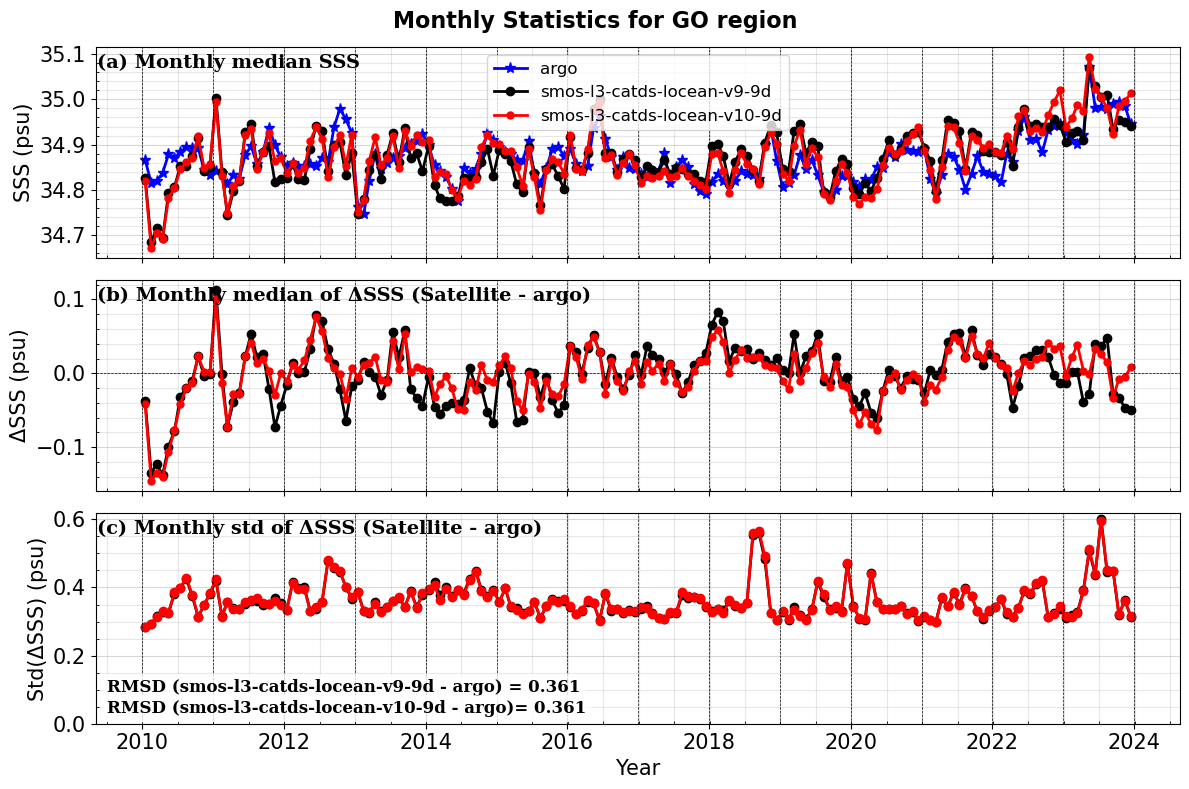

In [11]:
def create_monthly_statistics_plot(monthly_stats_sat1, monthly_stats_sat2, 
                                 region_name, insitu_name, sat1_name, sat2_name):
    """
    Create a three-panel plot showing monthly SSS statistics
    
    Parameters:
    -----------
    monthly_stats_sat1, monthly_stats_sat2 : pandas.DataFrame or xarray.Dataset
        Monthly statistics data containing date, median_sss, median_sss_sat, 
        median_deltas, std_deltas columns
    region_name : str
        Name of the region
    insitu_name : str
        Name of in-situ dataset
    sat1_name, sat2_name : str
        Names of satellite datasets
    """
    
    # Create figure and subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    fig.suptitle(f'Monthly Statistics for {region_name} region', 
                fontsize=16, fontweight='bold')
    
    # Common styling parameters
    major_tick_params = {'axis': 'both', 'which': 'major', 'labelsize': 15}
    minor_tick_params = {'axis': 'both', 'which': 'minor', 'direction': 'in'}
    grid_params_minor = {'which': 'minor', 'alpha': 0.3}
    grid_params_major = {'which': 'major', 'alpha': 0.5}
    
    # Year range for vertical lines (adjust as needed)
    max_year = pd.to_datetime(monthly_stats_sat1.date.values).max().year
    min_year = pd.to_datetime(monthly_stats_sat1.date.values).min().year
    year_range = range(min_year, max_year + 2)
    
    # Subplot 1: Monthly median SSS
    ax1 = axes[0]
    ax1.plot(monthly_stats_sat1.date, monthly_stats_sat1.median_sss, 
             '*-', linewidth=2, markersize=8, label=insitu_name, color='blue')
    ax1.plot(monthly_stats_sat1.date, monthly_stats_sat1.median_sss_sat, 
             'o-', linewidth=2, markersize=6, label=sat1_name, color='black')
    ax1.plot(monthly_stats_sat2.date, monthly_stats_sat2.median_sss_sat, 
             'o-', linewidth=2, markersize=5, label=sat2_name, color='red')
    
    # Add vertical lines for years
    for year in year_range:
        year_start = datetime(year, 1, 1)
        ax1.axvline(x=year_start, color='k', linestyle='--', linewidth=0.5)
    
    # Styling
    ax1.tick_params(**major_tick_params)
    ax1.tick_params(**minor_tick_params)
    ax1.minorticks_on()
    ax1.grid(True, **grid_params_minor)
    ax1.grid(True, **grid_params_major)
    ax1.set_xticklabels([])  # Remove x-axis labels
    ax1.set_ylabel('SSS (psu)', fontsize=15)
    ax1.legend(fontsize=12, loc='best')
    ax1.text(0.001, 0.9, '(a) Monthly median SSS',
             transform=ax1.transAxes, fontweight='bold',
             fontsize=14, fontfamily='serif')
    
    # Subplot 2: Monthly median of ΔSSS
    ax2 = axes[1]
    ax2.plot(monthly_stats_sat1.date, monthly_stats_sat1.median_deltas, 
             'o-', linewidth=2, markersize=6, label=sat1_name, color='black')
    ax2.plot(monthly_stats_sat2.date, monthly_stats_sat2.median_deltas, 
             'o-', linewidth=2, markersize=5, label=sat2_name, color='red')
    
    # Add vertical lines for years
    for year in year_range:
        year_start = datetime(year, 1, 1)
        ax2.axvline(x=year_start, color='k', linestyle='--', linewidth=0.5)
    
    # Add horizontal line at y=0
    ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    
    # Styling
    ax2.tick_params(**major_tick_params)
    ax2.tick_params(**minor_tick_params)
    ax2.minorticks_on()
    ax2.grid(True, **grid_params_minor)
    ax2.grid(True, **grid_params_major)
    ax2.set_xticklabels([])  # Remove x-axis labels
    ax2.set_ylabel('ΔSSS (psu)', fontsize=15)  # Corrected y-label with units
    ax2.text(0.001, 0.9, f'(b) Monthly median of ΔSSS (Satellite - {insitu_name})',
             transform=ax2.transAxes, fontweight='bold',
             fontsize=14, fontfamily='serif')
    
    # Subplot 3: Monthly std of ΔSSS
    ax3 = axes[2]
    ax3.plot(monthly_stats_sat1.date, monthly_stats_sat1.std_deltas, 
             'o-', linewidth=2, markersize=6, label=sat1_name, color='black')
    ax3.plot(monthly_stats_sat2.date, monthly_stats_sat2.std_deltas, 
             'o-', linewidth=2, markersize=6, label=sat2_name, color='red')
    
    # Set y-axis to start from 0
    ax3.set_ylim(bottom=0)
    
    # Add vertical lines for years
    for year in year_range:
        year_start = datetime(year, 1, 1)
        ax3.axvline(x=year_start, color='k', linestyle='--', linewidth=0.5)
    
    # Styling
    ax3.tick_params(**major_tick_params)
    ax3.tick_params(**minor_tick_params)
    ax3.minorticks_on()
    ax3.grid(True, **grid_params_minor)
    ax3.grid(True, **grid_params_major)
    ax3.set_ylabel('Std(ΔSSS) (psu)', fontsize=15)  # Corrected y-label with units
    ax3.set_xlabel('Year', fontsize=15)
    ax3.text(0.001, 0.9, f'(c) Monthly std of ΔSSS (Satellite - {insitu_name})',
             transform=ax3.transAxes, fontweight='bold',
             fontsize=14, fontfamily='serif')
    ax3.text(0.01, 0.15, f'RMSD ({sat1_name} - {insitu_name}) = {monthly_stats_sat1.std_deltas.mean():.3f}',
             transform=ax3.transAxes, fontweight='bold',
             fontsize=12, fontfamily='serif',bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.3'))
    ax3.text(0.01, 0.05, f'RMSD ({sat2_name} - {insitu_name})= {monthly_stats_sat2.std_deltas.mean():.3f}',
             transform=ax3.transAxes, fontweight='bold',
             fontsize=12, fontfamily='serif',bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.3'))
    # Adjust layout to prevent overlap
    plt.tight_layout()
    return fig, axes


# Create the plot with the selected widgets
fig, axes = create_monthly_statistics_plot(
    monthly_stats_sat1, monthly_stats_sat2, 
    region_widget.value, insitu_widget.value, 
    sat1_widget.value, sat2_widget.value
)
plt.show()

fig_name=f'../output/figures/pimep-mdb-figure_{region_widget.value}_{sat1_widget.value}_vs_{sat2_widget.value}_{insitu_widget.value}_Scatterplot-SSSdiff-vs-Time'
fig.savefig(fig_name, dpi=150, bbox_inches='tight')

## Make Griddata STATS

In [12]:
# Step 1: Perform grid data statistics
result1 = make_griddata_stat(
    x=ds1.LONGITUDE, y=ds1.LATITUDE, z=ds1.SSS_Satellite_product,
    space_res='One_degree',
    opt_region='GLOBAL',
    opt_variable='SSS',
    weight=1,
    opt_plot=0,
    use_scipy=True  # Force scipy method for large dataset
)

result2 = make_griddata_stat(
    x=ds2.LONGITUDE, y=ds2.LATITUDE, z=ds2.SSS_Satellite_product,
    space_res='One_degree',
    opt_region='GLOBAL',
    opt_variable='SSS',
    weight=1,
    opt_plot=0,
    use_scipy=True  # Force scipy method for large dataset
)

result3 = make_griddata_stat(
    x=ds1.LONGITUDE, y=ds1.LATITUDE, z=ds1.SSS_Satellite_product-ds1.SSS,
    space_res='One_degree',
    opt_region='GLOBAL',
    opt_variable='SSS',
    weight=1,
    opt_plot=0,
    use_scipy=True  # Force scipy method for large dataset
)

result4 = make_griddata_stat(
    x=ds2.LONGITUDE, y=ds2.LATITUDE, z=ds2.SSS_Satellite_product-ds2.SSS,
    space_res='One_degree',
    opt_region='GLOBAL',
    opt_variable='SSS',
    weight=1,
    opt_plot=0,
    use_scipy=True  # Force scipy method for large dataset
)
    
# Data analysis and summary
print("\n" + "-"*100)
print("FINAL RESULTS SUMMARY")
print("-"*100)

results = [result1, result2, result3]
labels = [sat1_widget.value, sat2_widget.value, insitu_widget.value]

valid_cells = [~np.isnan(r['MEAN']) for r in results]
shapes = [r['MEAN'].shape for r in results]
resolutions = [r['Space_res'] for r in results]
regions = [r['opt_region'] for r in results]

print(f"Products              : {' | '.join(labels)}")
print(f"Grid dimensions       : {' | '.join(str(s) for s in shapes)}")
print(f"Grid resolution       : {' | '.join(resolutions)}")
print(f"Region                : {' | '.join(regions)}")
print(f"Valid grid cells      : {' | '.join(f'{np.sum(v)} ({np.sum(v)/v.size*100:.1f}%)' for v in valid_cells)}")
print(f"Global mean SSS       : {' | '.join(f'{np.nanmean(r["MEAN"]):.3f}' for r in results)}")
print(f"Global std SSS        : {' | '.join(f'{np.nanstd(r["MEAN"]):.3f}' for r in results)}")
print(f"Global SSS range      : {' | '.join(f'{np.nanmin(r["MEAN"]):.3f} to {np.nanmax(r["MEAN"]):.3f}' for r in results)}")
print(f"Average data per cell : {' | '.join(f'{np.nanmean(r["ND"]):.1f}' for r in results)}")
print(f"Max data in a cell    : {' | '.join(f'{np.nanmax(r["ND"]):.0f}' for r in results)}")



----------------------------------------------------------------------------------------------------
FINAL RESULTS SUMMARY
----------------------------------------------------------------------------------------------------
Products              : smos-l3-catds-locean-v9-9d | smos-l3-catds-locean-v10-9d | argo
Grid dimensions       : (180, 360) | (180, 360) | (180, 360)
Grid resolution       : One_degree | One_degree | One_degree
Region                : GLOBAL | GLOBAL | GLOBAL
Valid grid cells      : 33769 (52.1%) | 33769 (52.1%) | 33769 (52.1%)
Global mean SSS       : 34.691 | 34.694 | -0.004
Global std SSS        : 1.581 | 1.581 | 0.240
Global SSS range      : 4.611 to 41.078 | 4.682 to 41.130 | -10.641 to 5.549
Average data per cell : 27.4 | 27.4 | 27.4
Max data in a cell    : 2083 | 2083 | 2083


## Plot Maps : Density, Mean SSS, Std SSS 

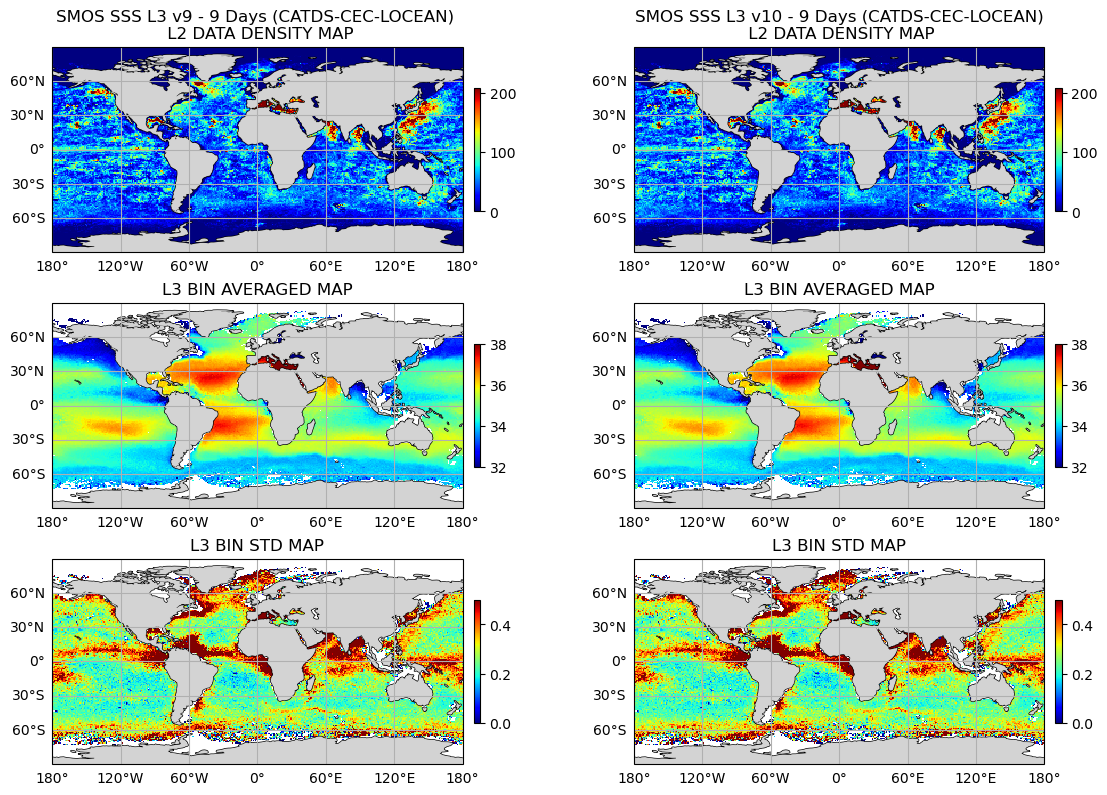

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
for ax in axes.flat:
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=2)

# Use more efficient plotting parameters
plot_kwargs = {'shading': 'auto', 'rasterized': True}
    
# Data density plot
im1 = axes[0,0].pcolormesh(
            result1['LON'], result1['LAT'], result1['ND'], 
            vmin=0, vmax=0.1*np.nanmax(result1['ND']), transform=ccrs.PlateCarree(),
            cmap='jet', **plot_kwargs)
axes[0,0].coastlines(resolution='110m')
gl = axes[0,0].gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
axes[0,0].set_title(f'{sat1_widget.label} \n L2 DATA DENSITY MAP')
plt.colorbar(im1, ax=axes[0,0], shrink=0.6, pad=0.02)

im2 = axes[0,1].pcolormesh(
            result2['LON'], result2['LAT'], result2['ND'], 
            vmin=0, vmax=0.1*np.nanmax(result2['ND']), transform=ccrs.PlateCarree(),
            cmap='jet', **plot_kwargs)
axes[0,1].coastlines(resolution='110m')
gl = axes[0,1].gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
axes[0,1].set_title(f'{sat2_widget.label}\n L2 DATA DENSITY MAP')
plt.colorbar(im2, ax=axes[0,1], shrink=0.6, pad=0.02)

# Mean plot
im3 = axes[1,0].pcolormesh(
    result1['LON'], result1['LAT'], result1['MEAN'], transform=ccrs.PlateCarree(),
    vmin=32, vmax=38, 
    cmap='jet', **plot_kwargs)
axes[1,0].coastlines(resolution='110m')
gl = axes[1,0].gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
axes[1,0].set_title('L3 BIN AVERAGED MAP')
plt.colorbar(im3, ax=axes[1,0], shrink=0.6, pad=0.02)

# Mean plot
im4 = axes[1,1].pcolormesh(
    result2['LON'], result2['LAT'], result2['MEAN'], transform=ccrs.PlateCarree(),
    vmin=32, vmax=38, 
    cmap='jet', **plot_kwargs)
axes[1,1].coastlines(resolution='110m')
gl = axes[1,1].gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
axes[1,1].set_title('L3 BIN AVERAGED MAP')
plt.colorbar(im4, ax=axes[1,1], shrink=0.6, pad=0.02)

# STD plot
im5 = axes[2,0].pcolormesh(
    result1['LON'], result1['LAT'], result1['STD'], 
    vmin=0, vmax=0.5, transform=ccrs.PlateCarree(),
    cmap='jet', **plot_kwargs)
axes[2,0].coastlines(resolution='110m')
gl = axes[2,0].gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
axes[2,0].set_title('L3 BIN STD MAP')
plt.colorbar(im5, ax=axes[2,0], shrink=0.6, pad=0.02)

im6 = axes[2,1].pcolormesh(
    result2['LON'], result2['LAT'], result2['STD'], 
    vmin=0, vmax=0.5, transform=ccrs.PlateCarree(),
    cmap='jet', **plot_kwargs)
axes[2,1].coastlines(resolution='110m')
gl = axes[2,1].gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
axes[2,1].set_title('L3 BIN STD MAP')
plt.colorbar(im6, ax=axes[2,1], shrink=0.6, pad=0.02)


plt.tight_layout()
plt.show()

## Plot the map of the standard deviation of Satellite - In situ in each grid cell

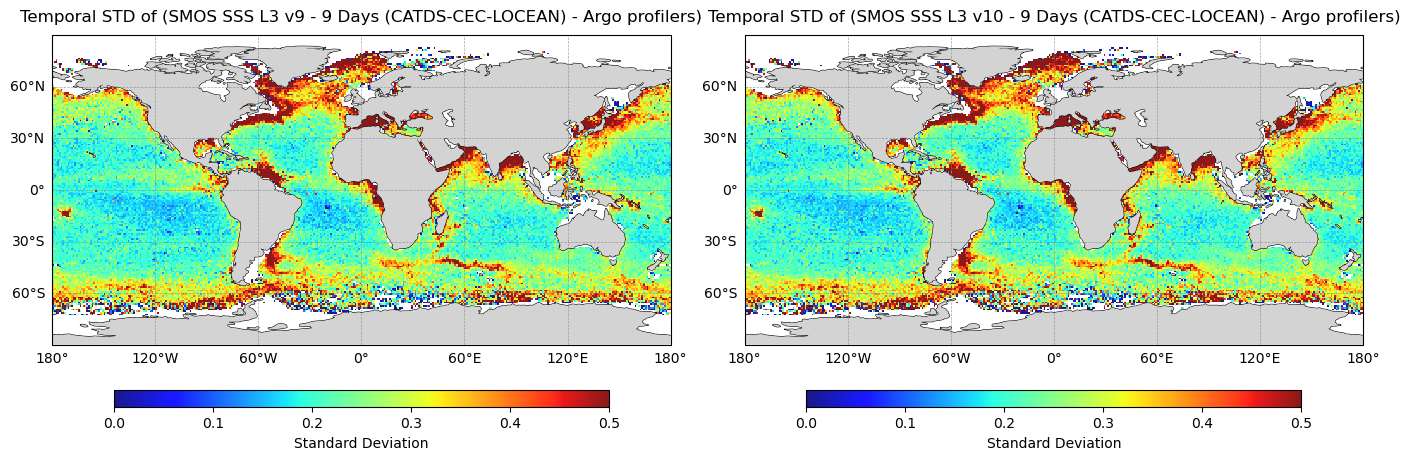

In [14]:
# Create figure with better spacing
fig, axes = plt.subplots(1, 2, figsize=(14, 6), 
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Common map features and styling
def setup_map_features(ax):
    """Apply common map features to an axis"""
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=2)
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=1)
    ax.coastlines(resolution='110m', linewidth=0.8, color='black')
    
    # Better gridline configuration
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, 
                      color='gray', alpha=0.7, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    return gl

# Apply features to both axes
for ax in axes.flat:
    setup_map_features(ax)

# Improved plotting parameters  
plot_kwargs = {
    'shading': 'auto', 
    'rasterized': True,
    'alpha': 0.9  # Slight transparency for better map visibility
}

# Define consistent colormap and normalization
vmin, vmax = 0, 0.5
cmap = 'jet'  # Consider more perceptually uniform colormap

# STD plot 1
im1 = axes[0].pcolormesh(
    result3['LON'], result3['LAT'], result3['STD'],
    vmin=vmin, vmax=vmax, 
    transform=ccrs.PlateCarree(),
    cmap=cmap, **plot_kwargs
)
axes[0].set_title(f'Temporal STD of ({sat1_widget.label} - {insitu_widget.label})', fontsize=12, pad=10)

# STD plot 2  
im2 = axes[1].pcolormesh(
    result4['LON'], result4['LAT'], result4['STD'],
    vmin=vmin, vmax=vmax,
    transform=ccrs.PlateCarree(), 
    cmap=cmap, **plot_kwargs
)
axes[1].set_title(f'Temporal STD of ({sat2_widget.label} - {insitu_widget.label})', fontsize=12, pad=10)

# Improved colorbar setup
# Horizontal colorbar setup
cbar_kwargs = {
    'shrink': 0.8, 
    'pad': 0.08, 
    'aspect': 30,
    'orientation': 'horizontal',
    'label': 'Standard Deviation'
}

# Add colorbars
cbar1 = plt.colorbar(im1, ax=axes[0], **cbar_kwargs)
cbar2 = plt.colorbar(im2, ax=axes[1], **cbar_kwargs)

# Optional: Set extent if you want to focus on specific regions
# axes[0].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
# axes[1].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

## Plot the standard deviation difference between two satellite datasets.

Data range: -0.905228 to 1.315957
5th percentile: -0.024170, 95th percentile: 0.018359
Colorbar range: -0.024170 to 0.024170
Data range: -0.905228 to 1.315957
Number of pixels where STD > 0: 16361 (48.45%) : smos-l3-catds-locean-v10-9d is better
Number of pixels where STD = 0: 528 (1.56%) : Both are equal
Number of pixels where STD < 0: 16880 (49.99%) : smos-l3-catds-locean-v9-9d is better


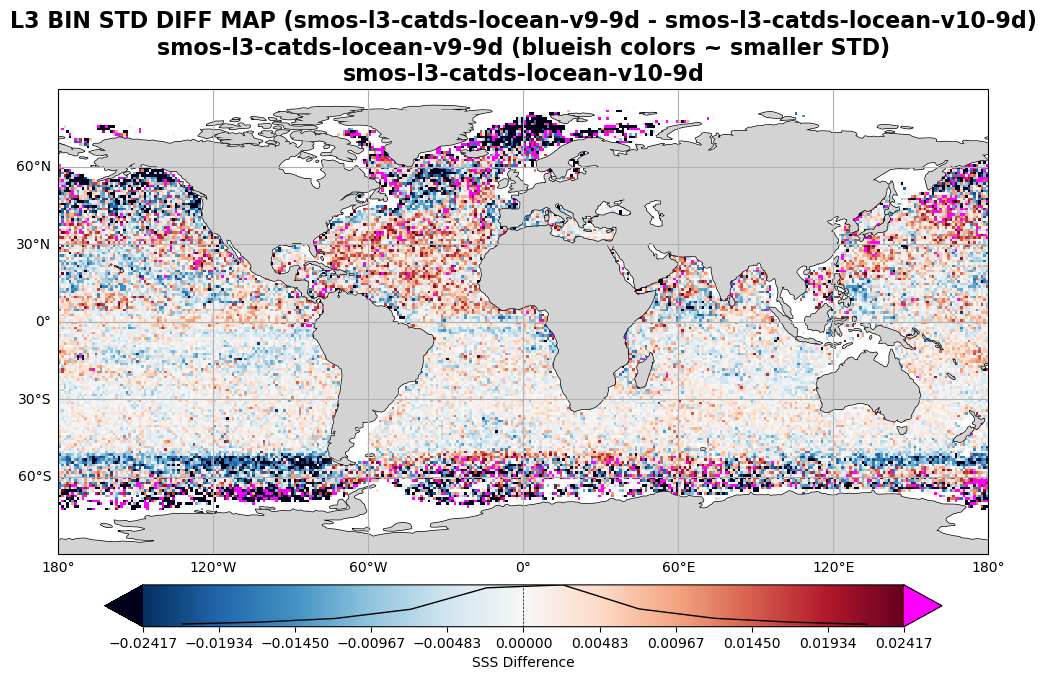

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_std_difference_map(result1, result2, sat1_name, sat2_name, 
                           tick_interval=0.001, figsize=(12, 8)):
    """
    Plot the standard deviation difference between two satellite datasets.
    
    Parameters:
    -----------
    result1, result2 : dict or xarray.Dataset
        Datasets containing 'STD', 'LON', 'LAT' variables
    sat1_name, sat2_name : str
        Names of the satellites for labeling
    tick_interval : float
        Interval for colorbar ticks and levels
    figsize : tuple
        Figure size (width, height)
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    
    # Calculate STD difference
    std_diff = result1['STD'] - result2['STD']
    
    # Debug: Check data range
    data_min = np.nanmin(std_diff)
    data_max = np.nanmax(std_diff)
    print(f"Data range: {data_min:.6f} to {data_max:.6f}")
    
    # Calculate symmetric colorbar limits using percentiles
    # Calculate symmetric colorbar limits using percentiles
    percentiles = [np.nanpercentile(std_diff, p) for p in [5, 95]]
    print(f"5th percentile: {percentiles[0]:.6f}, 95th percentile: {percentiles[1]:.6f}")
    
    # Always use symmetric range for red-white-blue colorbar
    cmax = np.max(np.abs(percentiles))  # Use absolute max for symmetric range
    cmin = -cmax
    print(f"Colorbar range: {cmin:.6f} to {cmax:.6f}")
    print(f"Data range: {data_min:.6f} to {data_max:.6f}")
    
    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=figsize, 
                          subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=2)
    ax.coastlines(resolution='110m')
    
    # Plot settings for efficiency - use simple vmin/vmax instead of BoundaryNorm
    plot_kwargs = {
        'shading': 'auto', 
        'rasterized': True,
        'transform': ccrs.PlateCarree(),
        'cmap': 'RdBu_r',  # Always red-white-blue: red=negative, white=zero, blue=positive
        'vmin': cmin,      # Simple approach - just set min and max values
        'vmax': cmax
    }
    
    # Create the main plot
    im = ax.pcolormesh(result1['LON'], result1['LAT'], std_diff, **plot_kwargs)
    
    # Set colormap extremes
    im.cmap.set_over('magenta')
    im.cmap.set_under([0, 0, 0.1])
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False
    
    # Add title
    title = (f'L3 BIN STD DIFF MAP ({sat1_name} - {sat2_name})\n'
             f'{sat1_name} (blueish colors ~ smaller STD)\n{sat2_name}')
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    # Add colorbar with histogram - simple approach
    cb = plt.colorbar(im, ax=ax, shrink=0.9, 
                     orientation='horizontal', extend='both', pad=0.05)
    cb.set_label('SSS Difference')
    
    # Add manual ticks centered on zero
    n_ticks = 11  # Odd number to include zero
    tick_values = np.linspace(cmin, cmax, n_ticks)
    tick_values[n_ticks//2] = 0.0  # Ensure exact zero
    cb.set_ticks(tick_values)
    
    # Add histogram to colorbar
    add_histogram_to_colorbar(cb, std_diff, cmin, cmax, tick_interval)

    print(f"Number of pixels where STD > 0: {np.sum(std_diff > 0)} ({np.sum(std_diff > 0) / np.sum(~np.isnan(std_diff)) * 100:.2f}%) : {sat2_name} is better")
    print(f"Number of pixels where STD = 0: {np.sum(std_diff == 0)} ({np.sum(std_diff == 0) / np.sum(~np.isnan(std_diff)) * 100:.2f}%) : Both are equal")
    print(f"Number of pixels where STD < 0: {np.sum(std_diff < 0)} ({np.sum(std_diff < 0) / np.sum(~np.isnan(std_diff)) * 100:.2f}%) : {sat1_name} is better")

    return fig, ax

def add_histogram_to_colorbar(colorbar, data, cmin, cmax, tick_interval):
    """
    Add a histogram overlay to the colorbar.
    
    Parameters:
    -----------
    colorbar : matplotlib colorbar object
    data : array-like
        Data to histogram
    cmin, cmax : float
        Range for histogram
    tick_interval : float
        Bin width for histogram
    """
    # Flatten data and remove NaNs
    data_clean = data.ravel()
    data_clean = data_clean[~np.isnan(data_clean)]
    
    # Create histogram
    n_bins = int((cmax - cmin) / tick_interval) + 1  
    #print(f"Number of bins: {n_bins}, Interval: {tick_interval}")
    counts, bin_edges = np.histogram(data_clean, bins=n_bins, range=(cmin, cmax))
    
    # Calculate bin centers
    bin_centers = bin_edges[:-1] + (tick_interval / 2.0)
    
    # Normalize counts and plot on colorbar
    normalized_counts = counts / np.max(counts)
    colorbar.ax.plot(bin_centers, normalized_counts, 'k', linewidth=1)
    
    # Add zero reference line
    colorbar.ax.axvline(x=0, color='k', linestyle='--', linewidth=0.5)


STD_DIFF = result1['STD']-result2['STD']

opt_caxis = [np.nanpercentile(STD_DIFF, 5), np.nanpercentile(STD_DIFF, 95)]
cmin = -np.max(opt_caxis) # min value for colorbar
cmax = np.max(opt_caxis) # max value for colorbar
ticks_range=0.1 # for equation  t_lab[key]=np.linspace(cmin,cmax, ((cmax-cmin) * ticks_range1+1) )           
levels=np.linspace(cmin,cmax, int((cmax-cmin) / ticks_range)+1 )
fig, ax = plot_std_difference_map(result1, result2, sat1_widget.value, sat2_widget.value, tick_interval=0.005, figsize=(12, 8))


## Make figures of $\Delta$SSS sorted by geophysical conditions

In [8]:
valid_mask = (~np.isnan(ds1.SSS_Satellite_product)) & (~np.isnan(ds1.SSS))

plot_deltaSSS_sorted_by_geophys_cond(
    sss_sat=ds1.SSS_Satellite_product,
    sss_insitu=ds1.SSS,
    ana=ds1,
    ind=valid_mask,
    pathout='../output/figures',
    fig_id=f'pimep-mdb-figure_{region_widget.value}_{sat1_widget.value}_{insitu_widget.value}',
    SAT_name='Satellite',
    insitu_database_name=insitu_widget.label,
    h1=150,
    mode='individual'
)

valid_mask = (~np.isnan(ds2.SSS_Satellite_product)) & (~np.isnan(ds2.SSS))

plot_deltaSSS_sorted_by_geophys_cond(
    sss_sat=ds2.SSS_Satellite_product,
    sss_insitu=ds2.SSS,
    ana=ds2,
    ind=valid_mask,
    pathout='../output/figures',
    fig_id=f'pimep-mdb-figure_{region_widget.value}_{sat2_widget.value}_{insitu_widget.value}',
    SAT_name='Satellite',
    insitu_database_name=insitu_widget.label,
    h1=150,
    mode='individual'
)


INFO:sss_geophysical_analysis_plotter:Saved plot: ../output/figures/pimep-mdb-figure_GO_smos-l3-catds-locean-v9-9d_argo_DeltaSSS-vs-sst.png
INFO:sss_geophysical_analysis_plotter:Saved plot: ../output/figures/pimep-mdb-figure_GO_smos-l3-catds-locean-v9-9d_argo_DeltaSSS-vs-sss.png
INFO:sss_geophysical_analysis_plotter:Saved plot: ../output/figures/pimep-mdb-figure_GO_smos-l3-catds-locean-v9-9d_argo_DeltaSSS-vs-ws.png
INFO:sss_geophysical_analysis_plotter:Saved plot: ../output/figures/pimep-mdb-figure_GO_smos-l3-catds-locean-v9-9d_argo_DeltaSSS-vs-RR.png
INFO:sss_geophysical_analysis_plotter:Saved plot: ../output/figures/pimep-mdb-figure_GO_smos-l3-catds-locean-v9-9d_argo_DeltaSSS-vs-Dist2coast.png
INFO:sss_geophysical_analysis_plotter:Saved plot: ../output/figures/pimep-mdb-figure_GO_smos-l3-catds-locean-v9-9d_argo_DeltaSSS-vs-SIC.png
INFO:sss_geophysical_analysis_plotter:Saved plot: ../output/figures/pimep-mdb-figure_GO_smos-l3-catds-locean-v9-9d_argo_DeltaSSS-vs-Dist2iceedge.png
INFO:s

<Figure size 640x480 with 0 Axes>

## Display the figures of $\Delta$SSS

In [22]:
def compare_satellite_figures(folder: str, sat1: str, sat2: str, region: str, insitu: str, suffix: str = ".png"):
    """
    Display two satellite comparison figures side by side with a dropdown to choose the variable.
    Args:
        folder: Directory containing figure PNGs.
        sat1: First satellite id (e.g., 'smos-l3-catds-locean-v10-9d').
        sat2: Second satellite id (e.g., 'smos-l3-catds-locean-v9-9d').
        region: Region id (e.g., 'GO').
        insitu: In-situ data id (e.g., 'argo').
        suffix: File extension (default: '.png')
    """
    # Filename prefix
    prefix1 = f"pimep-mdb-figure_{region}_{sat1.value}_{insitu}_"
    prefix2 = f"pimep-mdb-figure_{region}_{sat2.value}_{insitu}_"
    
    # List all files
    files = [f for f in sorted(os.listdir(folder)) if f.endswith(suffix)]
    
    # Extract figure variable names shared between sat1 and sat2
    name_figure_set = set()
    for f in files:
        if f.startswith(prefix1):
            name = f[len(prefix1):].replace(suffix, "")
            expected_other = f"{prefix2}{name}{suffix}"
            if expected_other in files:
                name_figure_set.add(name)
    
    name_figure_list = sorted(name_figure_set)
    
    if not name_figure_list:
        print(f"No matching figure pairs found in '{folder}' for region '{region}', insitu '{insitu}'")
        return
    
    # Widgets
    dropdown = widgets.Dropdown(
        options=name_figure_list,
        description='Figure:',
        layout=widgets.Layout(width='50%')
    )
    
    # Title labels for satellites
    sat1_widget = widgets.Label(
        value=f"{sat1.label}",
        layout=widgets.Layout(width='50%', justify_content='center')
    )
    
    sat2_widget = widgets.Label(
        value=f"{sat2.label}",
        layout=widgets.Layout(width='50%', justify_content='center')
    )
    
    output1 = widgets.Output()
    output2 = widgets.Output()
    
    def update_images(name_figure):
        file1 = f"{prefix1}{name_figure}{suffix}"
        file2 = f"{prefix2}{name_figure}{suffix}"
        
        output1.clear_output()
        output2.clear_output()
        
        with output1:
            display(Image(filename=os.path.join(folder, file1)))
        with output2:
            display(Image(filename=os.path.join(folder, file2)))
    
    def on_dropdown_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            update_images(change['new'])
    
    dropdown.observe(on_dropdown_change)
    
    # Initial display
    update_images(dropdown.value)
    
    display(widgets.VBox([
        dropdown,
        widgets.HBox([sat1_widget, sat2_widget]),
        widgets.HBox([output1, output2])
    ]))
    
compare_satellite_figures(
    folder="../output/figures",
    sat1=sat1_widget,
    sat2=sat2_widget,
    region=region_widget.value,
    insitu=insitu_widget.value
)   